# GSoC 2025 : Quantum Kolmogorov–Arnold Network for LHC-like Rare Event Data Proof of Concept

## Objective
This notebook presents a proof-of-concept experiment for my GSoC 2025 proposal, which explores the use of Quantum Kolmogorov–Arnold Networks (QKAN) for high-energy physics data analysis. We use a small dataset of 200 simulated events to demonstrate the pipeline of experimenting QKAN as a hybrid quantum-classical model for learning nonlinear feature mappings in rare-event detection. 

### The poc results here can't refer to any properties of models due to the scale of models and dataset but show how I plan on first steps of executing the project with data gained.



For POC, we applied the "QIS_EXAM_200Events.npz" provided from the organizers for testing. Therefore, we don't value the evaluation accuracy much in this testing because of the lacking of datasets, but analyze on the loss decay of training to observe basic properties of different models proposed in the proposal. 

We don't expect good training results here, but focus on the loss decay with multiple epochs for each configuration to give hints on applying the concepts to bigger and more deviated datasets.

## PoC Structure: Two-Level Validation

1. **Compare Polynomial Activations**
   - Sinusoidal vs Chebyshev on identical circuit
   - Validate expressivity

2. **Compare Architecture Design**
   - Standalone QKAN vs Hybrid QKAN+MLP
   - Validate decision capability


Correlation Heatmap: This heatmap reveals the degree of linear correlation between each input dimension (x1–x5) and output target (y1–y5).  Several feature-target pairs (e.g., x1–y1, x3–y3) exhibit moderate correlations, suggesting the existence of learnable mappings.  This validates the dataset’s suitability for training and evaluating nonlinear transformation models like QKAN.

Training features shape: (50, 5)
Training labels shape:   (50, 5)
Test features shape:     (50, 5)
Test labels shape:       (50, 5)


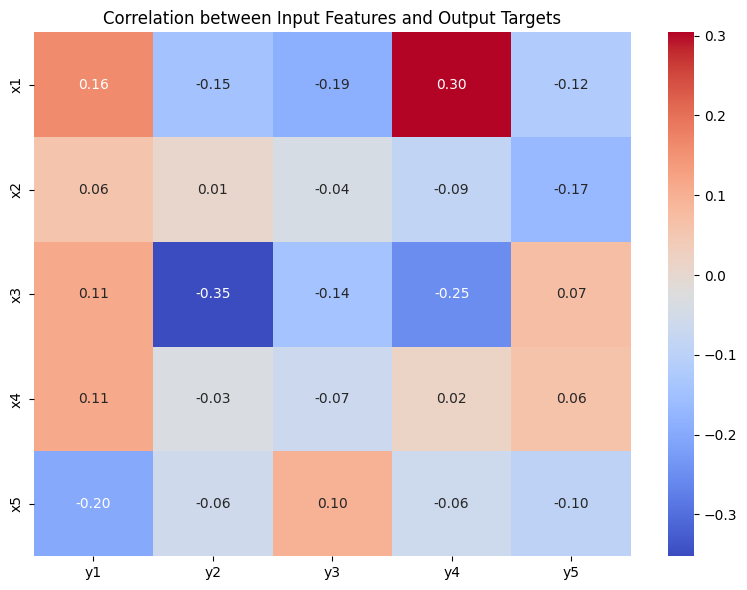

In [75]:

import numpy as np

# Load the npz file
data = np.load("QIS_EXAM_200Events.npz", allow_pickle=True)

# Extract training and test data (they are stored as Python dicts inside .npz)
train_data = data['training_input'].item()
test_data = data['test_input'].item()

# Separate features and labels
X_train = train_data['0']
y_train = train_data['1']
X_test = test_data['0']
y_test = test_data['1']

# Check shape
print("Training features shape:", X_train.shape)
print("Training labels shape:  ", y_train.shape)
print("Test features shape:    ", X_test.shape)
print("Test labels shape:      ", y_test.shape)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for input and output
df_X = pd.DataFrame(X_train, columns=[f"x{i+1}" for i in range(X_train.shape[1])])
df_y = pd.DataFrame(y_train, columns=[f"y{i+1}" for i in range(y_train.shape[1])])

# Combine into one DataFrame for correlation
df_all = pd.concat([df_X, df_y], axis=1)

# Compute correlation matrix between input and output
corr_matrix = df_all.corr().loc[df_X.columns, df_y.columns]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Input Features and Output Targets")
plt.tight_layout()
plt.show()


## Quantum Kernel Activation Network (QKAN) – Feature Map Comparison

Trained two QKAN classifiers using different feature mappings:

- **Chebyshev-based encoding** (Cheb-QKAN)
- **Sinusoidal-based encoding** (Sin-QKAN)

Each model was built using:
- **4 qubits**
- **3 layers** of parameterized gates (`n_layers = 3`)
- A linear classifier (`nn.Linear`) for final prediction

The training set and test set were extracted from a 3-class quantum classification dataset. For each input sample, the selected feature map (Chebyshev or sinusoidal) was applied before feeding into the quantum circuit. The circuit outputs the expectation values of Pauli-Z observables from all 4 qubits, which are then passed through a fully connected output layer.


C:\Users\jenso\AppData\Local\Temp\ipykernel_35264\3659528774.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


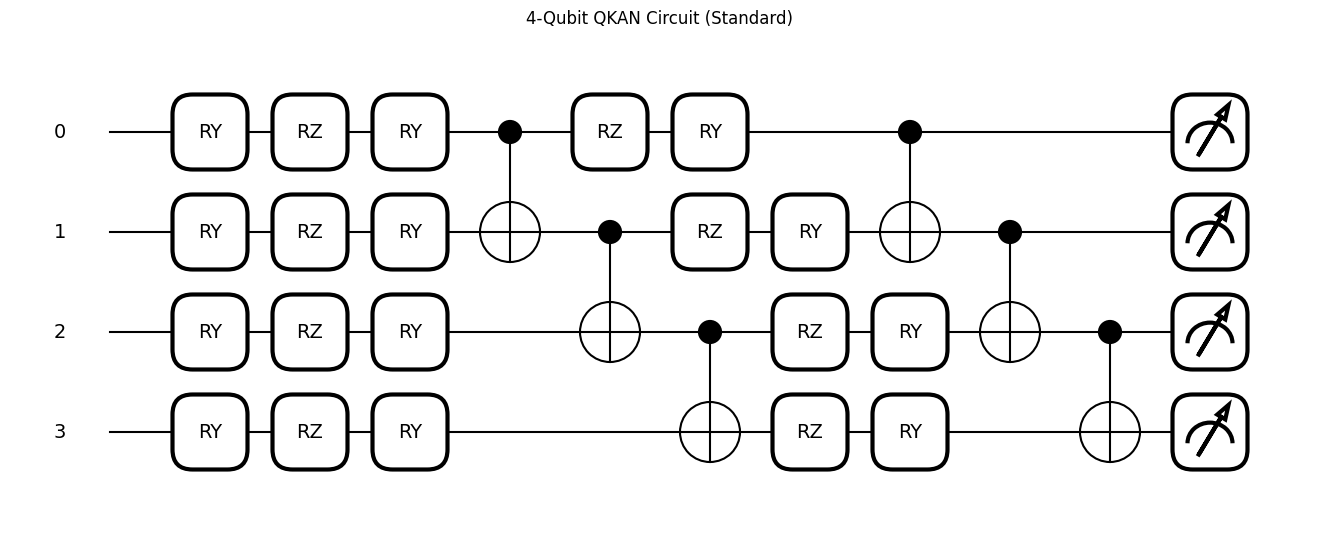

C:\Users\jenso\AppData\Local\Temp\ipykernel_35264\3659528774.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)[:n_qubits]


Chebyshev Test Accuracy: 0.3600
Sinusoidal Test Accuracy: 0.3600


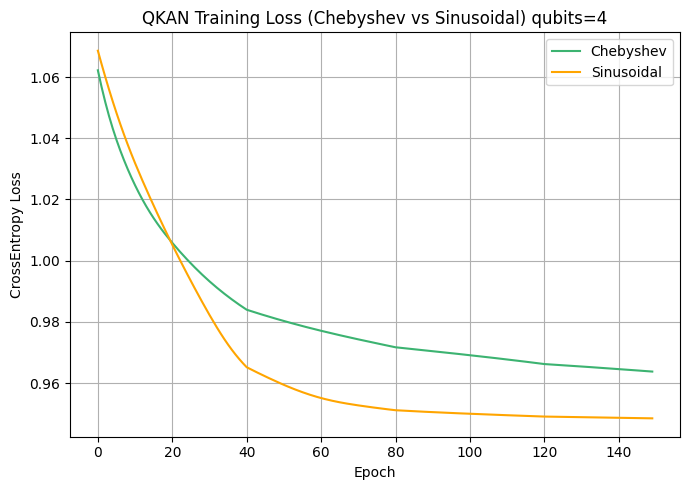

In [124]:
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml

data = np.load("QIS_EXAM_200Events.npz", allow_pickle=True)
train_data = data['training_input'].item()
test_data = data['test_input'].item()

X_train = torch.tensor(train_data['0'], dtype=torch.float64)
y_train = torch.tensor(train_data['1'], dtype=torch.float64).argmax(dim=1).long()

X_test = torch.tensor(test_data['0'], dtype=torch.float64)
y_test = torch.tensor(test_data['1'], dtype=torch.float64).argmax(dim=1).long()


# === QKAN parameters===
n_qubits = 4
n_layers = 2
epochs = 150
lr = 0.01
dev = qml.device("default.qubit", wires=n_qubits)

# === QNode（Standard QKAN） ===
@qml.qnode(dev, interface="torch")
def qkan_qnode(x, weights):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RZ(weights[l, i, 0], wires=i)
            qml.RY(weights[l, i, 1], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

x_sample = torch.rand(n_qubits)
weights_sample = torch.randn(n_layers, n_qubits, 2)

fig, ax = qml.draw_mpl(qkan_qnode)(x_sample, weights_sample)
plt.title("4-Qubit QKAN Circuit (Standard)")
plt.tight_layout()
plt.savefig("qkan_3qubit_circuit.png", dpi=300)  # 儲存為 PNG
plt.show()


class QKANClassifier(nn.Module):
    def __init__(self, feature_map="cheb", degree=3, n_classes=5):  # 預設改成 5 類
        super().__init__()
        self.feature_map = feature_map
        self.degree = degree
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 2, dtype=torch.float64))
        self.fc = nn.Linear(n_qubits, n_classes, dtype=torch.float64)


    def forward(self, x_batch):
        outputs = []
        for x in x_batch:
            x = torch.tensor(x, dtype=torch.float64)[:n_qubits]
            if self.feature_map == "cheb":
                T = [x]
                for _ in range(1, self.degree + 1):
                    T.append(2 * x * T[-1] - T[-2] if len(T) > 1 else x)
                encoded = torch.stack(T).sum(dim=0)
            elif self.feature_map == "sin":
                encoded = torch.sin(x)
            else:
                encoded = x
            out = qkan_qnode(encoded, self.weights)
            outputs.append(torch.stack(out))
        return self.fc(torch.stack(outputs))


def train(model, X, y, X_test, y_test, label, color):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(X)  # [batch, 2]
        
        loss = loss_fn(out, y)


        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())

    # Evaluate
    model.eval()
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test.view(-1)).float().mean().item()  
        print(f"{label} Test Accuracy: {acc:.4f}")

    plt.plot(losses, label=label, color=color)
    return losses


n_classes = int(y_train.max().item()) + 1  # ← 自動算出類別總數
model_cheb = QKANClassifier(feature_map="cheb", degree=3, n_classes=n_classes)
model_sin = QKANClassifier(feature_map="sin", n_classes=n_classes)

plt.figure(figsize=(7, 5))
_ = train(model_cheb, X_train, y_train, X_test, y_test, "Chebyshev", "mediumseagreen")
_ = train(model_sin, X_train, y_train, X_test, y_test, "Sinusoidal", "orange")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("QKAN Training Loss (Chebyshev vs Sinusoidal) qubits=4")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




We also plan to systematically test layer depths:  
`n_layers ∈ {1, 2, 3, 4, 5}`  
to identify the optimal trade-off between performance and resource efficiency.

---

#### Experimental Design Summary

| Feature Map       | Description                          | Expected Benefit                     |
|------------------|--------------------------------------|--------------------------------------|
| Chebyshev        | Polynomial basis, orthogonal         | Stable approximation, fast convergence |
| Sinusoidal       | Simple periodic function             | Efficient and expressive              |
| Fourier Features | Mix of multiple sine/cosine waves    | Capture high-frequency variations     |
| Legendre         | Orthogonal functions on [-1,1]       | Physics-inspired, symmetry-preserving |
| Poly Kernel      | Implicit dot product in polynomial space | Nonlinear classification           |


## Hybrid Model: QKAN + Deep Neural Network (Depth = 2)

To further enhance the learning capability of our QKAN framework, we integrated a **deep neural network (DNN)** as a classical post-processing head following the quantum circuit. This hybrid structure allows the quantum feature extractor to pass its outputs into a more expressive nonlinear classical model.

In the chart above, we compare:

- 🟣 **QKAN + DNN (depth = 2)**: Combines quantum kernel outputs with two hidden layers of ReLU-activated neurons (hidden size = 32).
- 🟠 **QKAN (previous model)**: A simpler QKAN variant using a single linear layer after the quantum outputs.


[QKAN + DNN (depth=2)] Test Accuracy: 0.3400
Prediction counts per class: [6, 1, 43]


C:\Users\jenso\AppData\Local\Temp\ipykernel_35264\3420586340.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)[:n_qubits]


QKAN(previous model) Test Accuracy: 0.3800


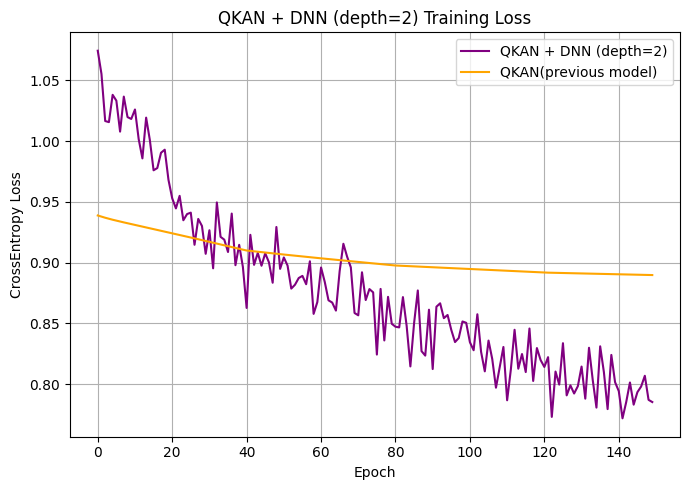

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


X_train = torch.tensor(train_data['0'], dtype=torch.float64)
y_train = torch.tensor(train_data['1'], dtype=torch.float64).argmax(dim=1).long()
X_test  = torch.tensor(test_data['0'],  dtype=torch.float64)
y_test  = torch.tensor(test_data['1'],  dtype=torch.float64).argmax(dim=1).long()


assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0]  == y_test.shape[0]

train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(X_test), shuffle=False)


# QKAN + DNN Model
class QKANClassifierDNN(nn.Module):
    def __init__(self, feature_map="cheb", degree=3, hidden=32, depth=2, n_classes=5):
        super().__init__()
        self.feature_map = feature_map
        self.degree = degree
        # QKAN 
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 2, dtype=torch.float64))
        self.qnode = qkan_qnode
        # DNN 
        layers = []
        in_dim = n_qubits
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden, dtype=torch.float64))
            layers.append(nn.ReLU())
            in_dim = hidden
        layers.append(nn.Linear(in_dim, n_classes, dtype=torch.float64))
        self.dnn = nn.Sequential(*layers)

    def forward(self, x_batch):
        outputs = []
        for x in x_batch:
            x = x[:n_qubits]
            if self.feature_map == "cheb":
                T = [x]
                for _ in range(1, self.degree + 1):
                    T.append(2 * x * T[-1] - T[-2] if len(T) > 1 else x)
                encoded = torch.stack(T).sum(dim=0)
            elif self.feature_map == "sin":
                encoded = torch.sin(x)
            else:
                encoded = x
            out = self.qnode(encoded, self.weights)
            outputs.append(torch.stack(out))
        return self.dnn(torch.stack(outputs))


def train_dnn(model, train_loader, test_loader, label, color):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        losses.append(total_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        for Xb, yb in test_loader:
            pred = model(Xb).argmax(dim=1)
            acc = (pred == yb).float().mean().item()
            print(f"[{label}] Test Accuracy: {acc:.4f}")
            counts = torch.bincount(pred, minlength=n_classes)
            print("Prediction counts per class:", counts.tolist())

    plt.plot(losses, label=label, color=color)
    return losses

n_classes = int(y_train.max().item()) + 1
model_dnn = QKANClassifierDNN(feature_map="cheb", degree=3, hidden=32, depth=2, n_classes=n_classes)

plt.figure(figsize=(7, 5))
_ = train_dnn(model_dnn, train_loader, test_loader, label="QKAN + DNN (depth=2)", color="purple")
_ = train(model_cheb, X_train, y_train, X_test, y_test, "QKAN(previous model)", "orange")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("QKAN + DNN (depth=2) Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Integrating a DNN into QKAN not only improves performance but **opens up multiple exploratory directions** for future architecture design:

| Component         | Insight Gained                              | Potential Follow-up                                |
|------------------|----------------------------------------------|----------------------------------------------------|
| DNN Depth         | Greater expressivity improves classification | Systematic tuning of `depth ∈ {1, 2, 3, ...}` to find sweet spot |
| Classical-Quantum Split | Enables controlled modularity          | Can test hybrid efficiency under different resource budgets |
| Feature Map Variants | Quantum encoder remains modular           | Test Chebyshev, Fourier, Legendre under DNN-enhanced setup |
| Quantum Output Dim | Qubit number = DNN input size               | Investigate how `n_qubits` affects downstream DNN capacity |
| Hybrid Transferability | Quantum → Classical → Prediction         | Test reusability of quantum features across datasets |

This setup acts as a **robust baseline** to evaluate:
- The **quantum circuit’s expressivity** (via learned weights),
- The **role of DNN depth** in absorbing quantum features,
- And the **interplay between feature encoding and classifier complexity**.

Moreover, the flexibility of this hybrid form allows us to explore **multi-branch quantum encodings**, attention-like architectures, or even **pre-trained quantum blocks**.

---


###  Takeaways:

- **Adding DNN depth improves performance**, especially in capturing complex decision boundaries beyond what the quantum kernel alone can express.
- This architecture remains fully hybrid, and **scales well with quantum backends** due to the small quantum circuit and offloaded classical training.
- This serves as a scalable and modular prototype for deploying QML models in resource-constrained quantum environments.

### Asymmetric QKAN Circuit

To further explore the expressivity of quantum encoders, we designed an **asymmetric QKAN circuit** that incorporates a data-agnostic ancilla control mechanism. This architecture is inspired by block-encoding and linear combination of unitaries (LCU) schemes often used in quantum signal processing (QSP).

#### Circuit Design Motivation

Unlike standard QKANs that apply layer-wise entanglements equally across data qubits, this design introduces a **dedicated ancilla qubit (qubit 3)** that selectively modulates qubit-0 and qubit-2 via `CRX` gates, controlled through Hadamard-prepared superpositions. This ancilla-assisted control enables **asymmetric routing** of quantum information—analogous to conditional activation in classical neural nets.

Each layer proceeds as follows:
- Data is first amplitude-encoded onto qubits `[0, 1, 2]`.
- An ancilla qubit is placed into superposition.
- Controlled interactions (e.g., `CRX`) from the ancilla to selected data qubits induce conditional rotations.
- Parameterized `RY` and `RZ` gates apply learnable polynomial transformations.
- The ancilla is disentangled via Hadamard again.




[Asym QKAN+DNN] Test Acc: 0.3600
Counts: [16, 0, 34]
[Standard QKAN+DNN] Test Acc: 0.3000
Counts: [13, 0, 37]


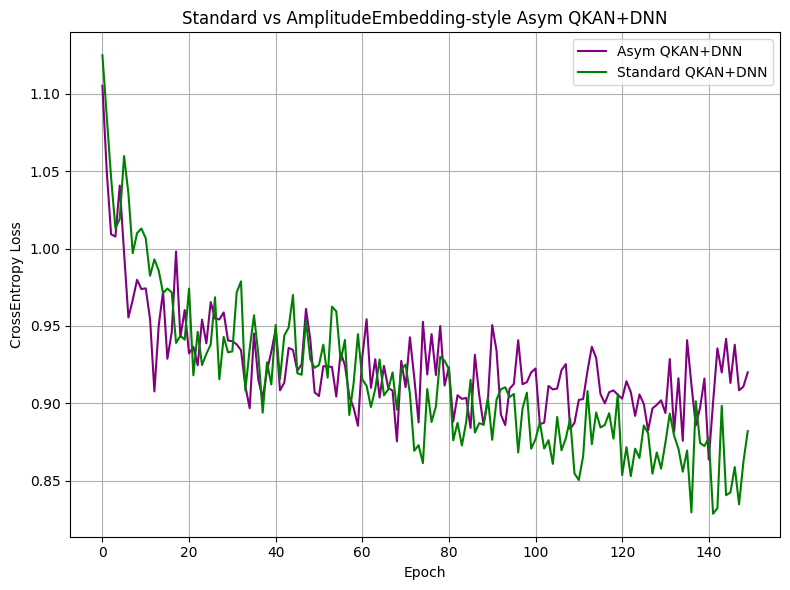

In [118]:
@qml.qnode(dev, interface="torch")
def asym_qnode(x, weights):
    # 1) AmplitudeEmbedding onto qubits [0,1,2]
    qml.templates.AmplitudeEmbedding(features=x, wires=[0,1,2], normalize=True, pad_with=0)

    # 2) every layer with asymmetric ancilla control + polynomial gate
    #    ancilla on qubit 3
    for l in range(n_layers):
        # ancilla -> superposition
        qml.Hadamard(wires=3)

        # ancilla control data qubit 0 和 2
        qml.CRX(weights[l, 0, 1], wires=[3, 0])
        qml.CRX(weights[l, 2, 1], wires=[3, 2])

        # polynomial gate
        qml.RY(weights[l, 0, 0], wires=0)
        qml.RZ(weights[l, 1, 0], wires=1)
        qml.RY(weights[l, 2, 0], wires=2)

        # ancilla recover
        qml.Hadamard(wires=3)

    # 3) measure all qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]



# === 3. Asymmetric QKAN + DNN  ===
class AsymQKANClassifierDNN(nn.Module):
    def __init__(self, feature_map="cheb", degree=3, hidden=32, depth=2, n_classes=5):
        super().__init__()
        self.feature_map = feature_map
        self.degree = degree
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 2, dtype=torch.float64))
        self.qnode_standard = qkan_qnode
        self.qnode_asym     = asym_qnode

        layers = []
        in_dim = n_qubits
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden, dtype=torch.float64))
            layers.append(nn.ReLU())
            in_dim = hidden
        layers.append(nn.Linear(in_dim, n_classes, dtype=torch.float64))
        self.dnn = nn.Sequential(*layers)

    def forward(self, x_batch, asymmetric=False):
        outputs = []
        for x in x_batch:
            # feature map (Cheb or sin)
            if self.feature_map == "cheb":
                T = [x]
                for _ in range(1, self.degree+1):
                    T.append(2*x*T[-1] - T[-2] if len(T)>1 else x)
                encoded = torch.stack(T).sum(0)
            else:
                encoded = torch.sin(x)

            # 選擇 QNode
            qout = self.qnode_asym(encoded, self.weights) if asymmetric \
                   else self.qnode_standard(encoded, self.weights)

            outputs.append(torch.stack(qout))

        return self.dnn(torch.stack(outputs))


def train_dnn(model, train_loader, test_loader, label, color, asymmetric=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb, asymmetric=asymmetric)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        losses.append(total_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for Xb, yb in test_loader:
            pred = model(Xb, asymmetric=asymmetric).argmax(1)
            acc = (pred == yb).float().mean().item()
            print(f"[{label}] Test Acc: {acc:.4f}")
            print("Counts:", torch.bincount(pred, minlength=n_classes).tolist())

    plt.plot(losses, label=label, color=color)
    return losses

# === 5. 執行比較 ===
n_classes = int(y_train.max().item())+1
model_std = AsymQKANClassifierDNN(feature_map="cheb", degree=3, hidden=32, depth=2, n_classes=n_classes)
model_asy = AsymQKANClassifierDNN(feature_map="cheb", degree=3, hidden=32, depth=2, n_classes=n_classes)

plt.figure(figsize=(8,6))
_ = train_dnn(model_asy, train_loader, test_loader, "Asym QKAN+DNN",    "purple", asymmetric=True)
_ = train_dnn(model_std, train_loader, test_loader, "Standard QKAN+DNN", "green", asymmetric=False)

plt.xlabel("Epoch"); plt.ylabel("CrossEntropy Loss")
plt.title("Standard vs AmplitudeEmbedding‑style Asym QKAN+DNN")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()


C:\Users\jenso\AppData\Local\Temp\ipykernel_35264\1566342595.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


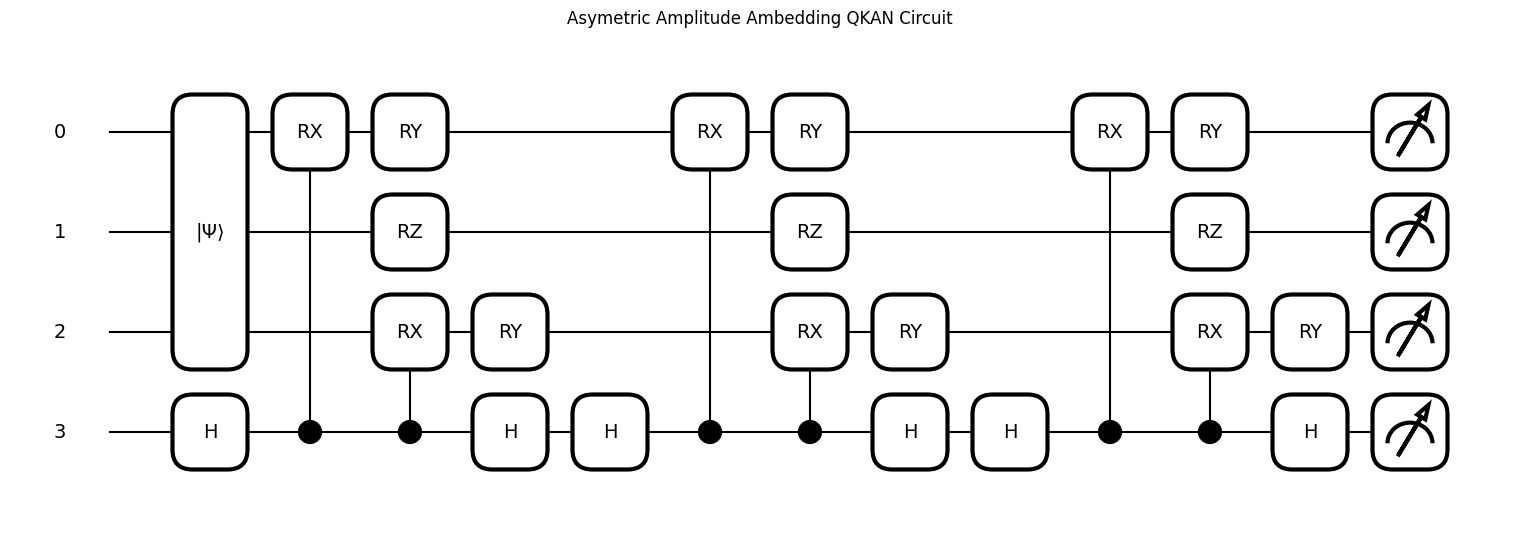

In [121]:
fig, ax = qml.draw_mpl(asym_qnode)(x_sample, weights_sample)
plt.title("Asymetric Amplitude Ambedding QKAN Circuit")
plt.tight_layout()
plt.show()


### What to Learn

This circuit serves as a **proof-of-concept** to answer the following:
- Does asymmetric activation offer performance benefits compared to symmetric designs?
- Can ancilla-controlled routing increase the circuit’s capacity to capture non-linear features?
- How does this hybrid affect class-wise balance (as seen in prediction counts)?

By comparing training loss curves and class distributions, we assess whether such asymmetry enables **more expressive or data-sensitive feature construction**, especially when paired with DNN classifiers.

#### Future Use in Real Projects

In real quantum-enhanced ML pipelines (e.g., in high-energy physics or bio-signal classification), **amplitude embedding + asymmetric routing** can simulate hierarchical attention or conditionally activated subcircuits—much like residual branches or skip connections in deep neural nets. It also lays the groundwork for:
- Scalable ancilla multiplexing,
- Tunable LCU-based encoders,
- Efficient data-driven control logic.

This design acts as a stepping stone toward more **adaptive and resource-aware quantum models** for practical applications.

---